In [2]:
import pandas as pd
import os
# cell border experimental code: 

import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

In [7]:
cd3_position = pd.read_csv('edge_test/tumor edge test CD3 position_Selection.csv' , skiprows=3)
cd3_position.drop(columns=['Unit', 'Category',
       'Collection', 'Time', 'CC3 catchall', 'CC3 real', 'CD103',
       'CD103+ cDC1', 'CD3','CD177','CD3-CD68', 'CD3-CD68+CD206', 'CD4',
       'CD45',  'Unnamed: 18'], inplace=True)

cd3_distance = pd.read_csv('edge_test/tumor edge test_CD3 distance to tumor edge_Selection.csv' , skiprows=3)
cd3_distance.drop(columns=['Category', 'Surfaces', 'Time',
       'CC3 catchall', 'CC3 real', 'CD103', 'CD103+ cDC1', 'CD177', 'CD3',
       'CD3-CD68', 'CD3-CD68+CD206', 'Unit','CD4', 'CD45', 'Unnamed: 16'], inplace=True)

# cd3_position.head()
cd3_final = cd3_position.merge(cd3_distance, on=["ID"], how='left').sort_values(by=['ID'], ascending=True)
cd3_final =  cd3_final[['ID','Position X', 'Position Y', 'Position Z',
       'Shortest Distance to Surfaces']].set_index('ID')
# cd3_final

dapi2_position = pd.read_csv('edge_test/tumor edge test DAPI position_Selection.csv' , skiprows=3)
dapi2_position.drop(columns=['Unit', 'Category',
       'Collection', 'Time', 'CC3 catchall', 'CC3 real', 'CD103',
       'CD103+ cDC1', 'CD3','CD177','CD3-CD68', 'CD3-CD68+CD206', 'CD4',
       'CD45',  'Unnamed: 18'], inplace=True)

dapi2_distance = pd.read_csv('edge_test/tumor edge test_DAPI distance to tumor edge_Selection.csv' , skiprows=3)
dapi2_distance.drop(columns=['Category', 'Surfaces', 'Time',
       'CC3 catchall', 'CC3 real', 'CD103', 'CD103+ cDC1', 'CD177', 'CD3',
       'CD3-CD68', 'CD3-CD68+CD206', 'Unit','CD4', 'CD45', 'Unnamed: 16'], inplace=True)

# cd3_position.head()
dapi2_final = dapi2_position.merge(dapi2_distance, on=["ID"], how='left').sort_values(by=['ID'], ascending=True)
dapi2_final =  dapi2_final[['ID','Position X', 'Position Y', 'Position Z',
       'Shortest Distance to Surfaces']].set_index('ID')
dapi2_final

/var/folders/bv/7wzy33ls6ln4ydwr6s8vwq8h0000gn/T/ipykernel_91342/455619731.py:18: DtypeWarning: Columns (8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dapi2_position = pd.read_csv('edge_test/tumor edge test DAPI position_Selection.csv' , skiprows=3)


,Position X,Position Y,Position Z,Shortest Distance to Surfaces
ID,,,,
0,87286.352,39678.461,2.373,256.589
1,87253.484,39703.367,6.589,279.778
2,87024.227,39933.770,6.702,174.885
3,86896.992,40064.652,5.901,55.385
4,87015.500,39945.977,5.861,164.362
...,...,...,...,...
62183,87404.539,36997.043,2.713,40.845
62184,87410.164,37034.875,0.963,78.880
62185,87404.609,37051.000,5.010,93.720


In [12]:

def point_to_segment_distances(points, seg_start, seg_end):
    """
    points: (N,2) array
    seg_start, seg_end: each (2,) array
    returns: (N,) array of distances from each point to the segment
    """
    v = seg_end - seg_start                      # (2,)
    w = points - seg_start                       # (N,2)

    t = np.einsum('ij,j->i', w, v) / np.dot(v, v)

    t_clamped = np.clip(t, 0.0, 1.0)             # (N,)
    proj = seg_start + t_clamped[:,None] * v     # (N,2)

    return np.linalg.norm(points - proj, axis=1)

In [16]:

# 1) Load your data
df1 =  cd3_final# columns “x” and “y”
pts = df1[['Position X', 'Position Y']].values             # shape (N,2) array

# 2) Compute the convex hull
hull = ConvexHull(pts)

edges = hull.simplices


all_dists = np.full(len(pts), np.inf)
for i, j in edges:
    start, end = pts[i], pts[j]
    d = point_to_segment_distances(pts, start, end)
    all_dists = np.minimum(all_dists, d)

# 5) Attach back to your DataFrame
df1['dist_to_hull'] = all_dists

# 6) (Optional) Inspect
graph_cd3 = df1
graph_cd3


,Position X,Position Y,Position Z,Shortest Distance to Surfaces,dist_to_hull
ID,,,,,
0,87286.352,39678.461,2.373,256.589,311.497421
21,87067.141,39897.441,2.333,205.241,244.710141
70,87082.531,39892.945,2.081,209.912,249.205250
292,87395.414,39635.039,4.682,180.723,278.707180
622,87085.406,40034.551,6.220,69.469,107.599084
...,...,...,...,...,...
58723,87405.586,37086.035,1.955,128.012,140.239987
58724,87411.445,37113.520,1.206,156.499,168.029973
58725,87410.750,37127.992,3.233,169.250,182.433091


In [17]:


# 1) Load your data
df2 =  dapi2_final    # columns “x” and “y”
pts = df2[['Position X', 'Position Y']].values           # shape (N,2) array

# 2) Compute the convex hull
hull = ConvexHull(pts)

# hull.simplices is an (E,2) array of index pairs (i, j)
# each representing an edge between pts[i] and pts[j].
edges = hull.simplices

# 3) Define a vectorized distance‐to‐segment function

# 4) Loop over edges, keep the minimum distance per point
all_dists = np.full(len(pts), np.inf)
for i, j in edges:
    start, end = pts[i], pts[j]
    d = point_to_segment_distances(pts, start, end)
    all_dists = np.minimum(all_dists, d)

# 5) Attach back to your DataFrame
df2['dist_to_hull'] = all_dists

# 6) (Optional) Inspect
graph_dapi2 = df2
graph_dapi2


,Position X,Position Y,Position Z,Shortest Distance to Surfaces,dist_to_hull
ID,,,,,
0,87286.352,39678.461,2.373,256.589,344.303829
1,87253.484,39703.367,6.589,279.778,344.728350
2,87024.227,39933.770,6.702,174.885,227.469084
3,86896.992,40064.652,5.901,55.385,106.869526
4,87015.500,39945.977,5.861,164.362,216.583741
...,...,...,...,...,...
62183,87404.539,36997.043,2.713,40.845,83.511607
62184,87410.164,37034.875,0.963,78.880,121.603161
62185,87404.609,37051.000,5.010,93.720,137.361276


In [18]:
print(graph_dapi2.columns, graph_cd3.columns)

Index(['Position X', 'Position Y', 'Position Z',
       'Shortest Distance to Surfaces', 'dist_to_hull'],
      dtype='object') Index(['Position X', 'Position Y', 'Position Z',
       'Shortest Distance to Surfaces', 'dist_to_hull'],
      dtype='object')


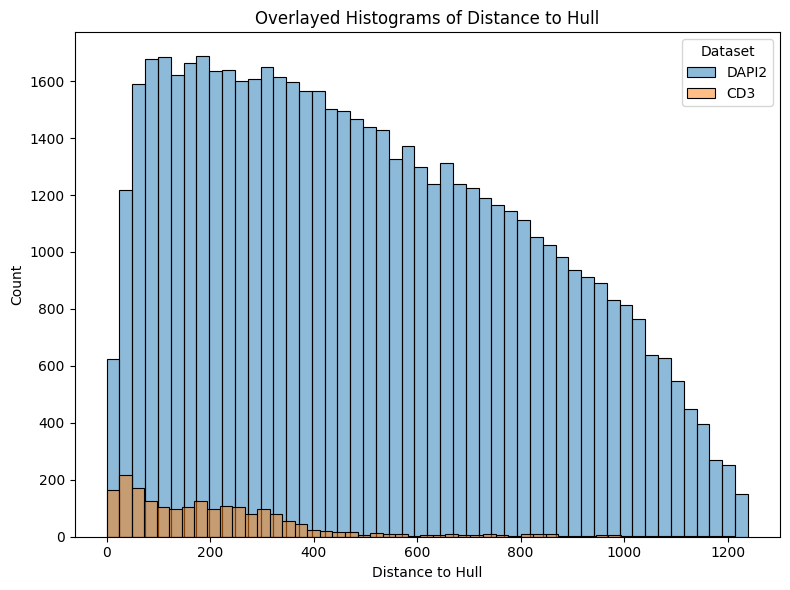

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))

# Plot DAPI2 distribution
sns.histplot(
    graph_dapi2['dist_to_hull'],
    bins=50,
    color='C0',            # first default seaborn color (blue)
    alpha=0.5,
    label='DAPI2',
    stat='count'
)

# Plot CD3 distribution
sns.histplot(
    graph_cd3['dist_to_hull'],
    bins=50,
    color='C1',            # second default seaborn color (orange)
    alpha=0.5,
    label='CD3',
    stat='count'
)

plt.title("Overlayed Histograms of Distance to Hull")
plt.xlabel("Distance to Hull")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()
